In [1]:
import math
import wave
import struct
import pdb
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# Audio will contain a long list of samples (i.e. floating point numbers describing the
# waveform).  If you were working with a very long sound you'd want to stream this to
# disk instead of buffering it all in memory list this.  But most sounds will fit in 
# memory.   

def append_silence(audio, sample_rate, duration_milliseconds=500):
    """
    Adding silence is easy - we add zeros to the end of our array
    """
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)): 
        audio.append(0.0)
    return audio

def append_sinewave(audio, sample_rate, 
                    freq = 440.0, 
                    duration_milliseconds=500, 
                    volume=1.0):
    """
    The sine wave generated here is the standard beep.  If you want something
    more aggresive you could try a square or saw tooth waveform.   Though there
    are some rather complicated issues with making high quality square and
    sawtooth waves... which we won't address here :) 
    """ 
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)):
        audio.append(volume * math.sin(2 * math.pi * freq * ( x / sample_rate )))
    return audio

def save_wav(audio, sample_rate, file_name):
    # Open up a wav file
    wav_file=wave.open(file_name,"w")

    # wav params
    nchannels = 1
    sampwidth = 2

    # 44100 is the industry standard sample rate - CD quality.  If you need to
    # save on file size you can adjust it downwards. The stanard for low quality
    # is 8000 or 8kHz.
    nframes = len(audio)
    comptype = "NONE"
    compname = "not compressed"
    wav_file.setparams((nchannels, sampwidth, sample_rate, nframes, comptype, compname))

    # WAV files here are using short, 16 bit, signed integers for the 
    # sample size.  So we multiply the floating point data we have by 32767, the
    # maximum value for a short integer.  NOTE: It is theortically possible to
    # use the floating point -1.0 to 1.0 data directly in a WAV file but not
    # obvious how to do that using the wave module in python.
    for sample in audio:
        wav_file.writeframes(struct.pack('h', int( sample * 32767.0 )))
        
    wav_file.close()
    return

def generate_tone_cloud(freq_list):
    audio = []
    sample_rate = 44100.0   
    
    freq_0 = freq_list[0]; freq_1 = freq_list[1]; freq_2 = freq_list[2];
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_0)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_1)
    audio = append_silence(audio = audio, sample_rate = sample_rate)
    audio = append_sinewave(audio = audio, sample_rate = sample_rate, freq = freq_2)
    
    # plt.plot(audio)
    # plt.show()
    # pdb.set_trace()
    return audio, sample_rate

In [3]:
def train_task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.2):
    freq_seq = np.arange(100,800,1) #array of possible true tones
    freq_low = [300,30]  #low freq condition is gaussian 
    freq_high = [500,30] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                # pdb.set_trace()
                nearest_tone = float(np.random.choice(np.concatenate((freq_seq[:10], freq_seq[-10:])),1)) #background freq is chosen from a uniform distribution that spans from 1-30 Hz.
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*freq_low[1] + freq_low[0],freq_low[0]-freq_low[1]),freq_low[0]+freq_low[1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - tone))]
                else:
                    tone = min(max(np.random.randn()*freq_high[1] + freq_high[0],freq_high[0]-freq_high[1]),freq_high[0]+freq_high[1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - tone))]
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
    return trial_tones, dist_chosen


In [12]:
# This is for the training part of the three tones expt.
training_trials, dist_chosen = train_task(n_trials = 50, n_tones = 3)

cnt_low = 0; cnt_high = 0
rows_csv = []
for i_trial in range(len(training_trials)):
    audio, sample_rate = generate_tone_cloud(training_trials[i_trial])    
    if dist_chosen[i_trial]:
        save_wav(audio, sample_rate, file_name = "soundfiles/tr_wave_low"+str(cnt_low)+".wav")
        rows_csv.append(["tr_wave_low"+str(cnt_low)+".wav", 'l'])
        cnt_low += 1 ; print(cnt_low)
    else:
        save_wav(audio, sample_rate, file_name = "soundfiles/tr_wave_high"+str(cnt_high)+".wav")
        rows_csv.append(["tr_wave_high"+str(cnt_high)+".wav", 'h'])
        cnt_high += 1 ; print(cnt_high)


1
> <ipython-input-12-9c2f2dd6a0e5>(6)<module>()
-> for i_trial in range(len(training_trials)):
(Pdb) exit


BdbQuit: 

In [7]:
# field names  
fields = ['Name', 'corrAns']  
    
# name of csv file  
filename = "train_three_tone_files.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv) 

In [8]:
def test_task(n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.2):
    freq_seq = np.arange(100,800,1) #array of possible true tones
    freq_low = [300,30]  #low freq condition is gaussian 
    freq_high = [500,30] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                # pdb.set_trace()
                nearest_tone = float(np.random.choice(freq_seq,1)) #background freq is chosen from a uniform distribution that spans from 1-30 Hz.
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*freq_low[1] + freq_low[0],freq_seq[0]),freq_seq[-1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - tone))]
                else:
                    tone = min(max(np.random.randn()*freq_high[1] + freq_high[0],freq_seq[0]),freq_seq[-1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - tone))]
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
    return trial_tones, dist_chosen

In [9]:
# Following is for the testing part of the three tones expt.
testing_trials, dist_chosen = test_task(n_trials = 125, n_tones = 3)

cnt_low = 0; cnt_high = 0
rows_csv = []
for i_trial in range(len(testing_trials)):
    audio, sample_rate = generate_tone_cloud(testing_trials[i_trial])    
    if dist_chosen[i_trial]:
        save_wav(audio, sample_rate, file_name = "soundfiles/tt_wave_low"+str(cnt_low)+".wav")
        rows_csv.append(["tt_wave_low"+str(cnt_low)+".wav", 'l'])
        cnt_low += 1 ; print(dist_chosen[i_trial], cnt_low)
    else:
        save_wav(audio, sample_rate, file_name = "soundfiles/tt_wave_high"+str(cnt_high)+".wav")
        rows_csv.append(["tt_wave_high"+str(cnt_high)+".wav", 'h'])
        cnt_high += 1 ; print(dist_chosen[i_trial], cnt_high)

True 1
False 1
False 2
True 2
True 3
True 4
False 3
False 4
True 5
True 6
True 7
True 8
True 9
True 10
True 11
False 5
False 6
False 7
False 8
False 9
True 12
True 13
False 10
False 11
False 12
False 13
False 14
True 14
True 15
False 15
True 16
True 17
True 18
True 19
True 20
True 21
True 22
True 23
False 16
True 24
False 17
True 25
False 18
True 26
False 19
True 27
False 20
False 21
False 22
False 23
True 28
True 29
True 30
True 31
False 24
False 25
True 32
True 33
False 26
True 34
False 27
False 28
True 35
True 36
False 29
False 30
True 37
False 31
False 32
False 33
False 34
False 35
False 36
False 37
False 38
True 38
True 39
False 39
True 40
False 40
True 41
True 42
False 41
True 43
False 42
True 44
True 45
True 46
True 47
False 43
True 48
False 44
False 45
False 46
False 47
True 49
True 50
True 51
True 52
True 53
True 54
True 55
False 48
False 49
False 50
False 51
True 56
False 52
False 53
False 54
False 55
True 57
False 56
True 58
True 59
False 57
True 60
True 61
False 58
True 62


In [10]:
# field names  
fields = ['Name', 'corrAns']  
    
# name of csv file  
filename = "test_three_tone_files.csv"
    
# writing to csv file  
with open(filename, 'w') as csvfile:  
    # creating a csv writer object  
    csvwriter = csv.writer(csvfile)          
    # writing the fields  
    csvwriter.writerow(fields)          
    # writing the data rows  
    csvwriter.writerows(rows_csv) 

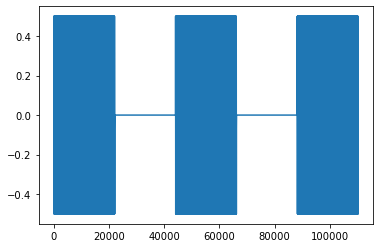

In [12]:
"""
Sample code from https://stackoverflow.com/questions/33879523/python-how-can-i-generate-a-wav-file-with-beeps
"""

audio = []
sample_rate = 44100.0


def append_silence(audio, duration_milliseconds=500):
    """
    Adding silence is easy - we add zeros to the end of our array
    """
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)): 
        audio.append(0.0)

    return audio


def append_sinewave(audio,
        freq=500.0, 
        duration_milliseconds=500, 
        volume=0.5):
    """
    The sine wave generated here is the standard beep.  If you want something
    more aggresive you could try a square or saw tooth waveform.   Though there
    are some rather complicated issues with making high quality square and
    sawtooth waves... which we won't address here :) 
    """ 
    num_samples = duration_milliseconds * (sample_rate / 1000.0)

    for x in range(int(num_samples)):
        audio.append(volume * math.sin(2 * math.pi * freq * ( x / sample_rate )))
    return audio


def save_wav(audio, file_name):
    # Open up a wav file
    wav_file=wave.open(file_name,"w")

    # wav params
    nchannels = 1

    sampwidth = 2

    # 44100 is the industry standard sample rate - CD quality.  If you need to
    # save on file size you can adjust it downwards. The stanard for low quality
    # is 8000 or 8kHz.
    nframes = len(audio)
    comptype = "NONE"
    compname = "not compressed"
    wav_file.setparams((nchannels, sampwidth, sample_rate, nframes, comptype, compname))

    # WAV files here are using short, 16 bit, signed integers for the 
    # sample size.  So we multiply the floating point data we have by 32767, the
    # maximum value for a short integer.  NOTE: It is theortically possible to
    # use the floating point -1.0 to 1.0 data directly in a WAV file but not
    # obvious how to do that using the wave module in python.
    for sample in audio:
        wav_file.writeframes(struct.pack('h', int( sample * 32767.0 )))

    wav_file.close()

    return

audio = append_sinewave(audio)
audio = append_silence(audio)
audio = append_sinewave(audio)
audio = append_silence(audio)
audio = append_sinewave(audio)
plt.plot(audio)
audio = save_wav(audio, file_name = "output5.wav")